# Formatting and split


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset

dataset = load_dataset('cifar10')

def format_data(split):
    images = np.array(split["img"])
    labels = np.array(split["label"])
    images = images.transpose(0, 3, 1, 2).astype(np.float32) / 255.0
    mean = images.mean(axis=(2, 3), keepdims=True)
    std = images.std(axis=(2, 3), keepdims=True)
    std[std == 0] = 1.0
    images = (images - mean) / std
    return images, labels

X_train_full, y_train_full = format_data(dataset["train"])
X_test, y_test = format_data(dataset["test"])

train_idxs = []
for i in range(10):
    class_idxs = np.where(y_train_full == i)[0]
    sampled_idxs = np.random.choice(class_idxs, 1000, replace=False)
    train_idxs.append(sampled_idxs)
train_idxs = np.concatenate(train_idxs)
np.random.shuffle(train_idxs)

X_train = X_train_full[train_idxs]
y_train = y_train_full[train_idxs]

In [7]:
def get_model():
    model = torchvision.models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

def model_train(model, loader, optimizer, criterion, device, augmentation_fn=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        if augmentation_fn:
            inputs.requires_grad = True
            inputs, targets = augmentation_fn(inputs, targets)
        optimizer.zero_grad()
        outputs = model(inputs)
        if targets.dim() > 1: # for ohe target
            loss = criterion(outputs, targets)
        else:
            loss = criterion(outputs, targets)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_acc = 100.0 * correct / total if total > 0 else 0
    return running_loss / len(loader), epoch_acc

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return 100.0 * correct / total

def train_model_aug(epochs, lr, augmentation_fn=None):
    device = "cuda"
    model = get_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    def criterion(outputs, targets):
        if targets.dim() > 1:
            return torch.mean(torch.sum(-targets * F.log_softmax(outputs, dim=1), dim=1))
        return F.cross_entropy(outputs, targets)

    train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
    test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)
    report_loader = DataLoader(train_ds, batch_size=100, shuffle=False)
    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}
    for epoch in range(epochs):
        loss, _ = model_train(model, train_loader, optimizer, criterion, device, augmentation_fn)
        train_acc = evaluate(model, report_loader, device)
        test_acc = evaluate(model, test_loader, device)
        history['train_loss'].append(loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")
    return history



In [8]:
LR = 0.001
EPOCHS = 10

# Q1. Resnet without augmentation
Final epoch test accuracy obtained without any augmentaiton is 57.54%


In [9]:
history_no_aug = train_model_aug(EPOCHS, LR)

Epoch 1/10 - Loss: 1.8280, Train Acc: 46.45%, Test Acc: 41.35%
Epoch 2/10 - Loss: 1.4236, Train Acc: 56.08%, Test Acc: 48.84%
Epoch 3/10 - Loss: 1.1952, Train Acc: 64.82%, Test Acc: 53.56%
Epoch 4/10 - Loss: 1.0213, Train Acc: 69.85%, Test Acc: 55.63%
Epoch 5/10 - Loss: 0.8487, Train Acc: 76.03%, Test Acc: 55.97%
Epoch 6/10 - Loss: 0.6968, Train Acc: 81.22%, Test Acc: 57.26%
Epoch 7/10 - Loss: 0.5760, Train Acc: 87.28%, Test Acc: 59.45%
Epoch 8/10 - Loss: 0.4235, Train Acc: 82.04%, Test Acc: 54.76%
Epoch 9/10 - Loss: 0.3626, Train Acc: 89.48%, Test Acc: 57.53%
Epoch 10/10 - Loss: 0.3025, Train Acc: 92.88%, Test Acc: 57.54%


# Q2: Mixup Augmentation

Final test accuracy obtained with alpha = 0.2 is60.32% while 58.19% for alpha = 0.4. With lower alpha, we got a better performance on both the test set and training set (from the plots at the end)

In [10]:
def mixup_aug(inputs, targets, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = inputs.size(0)
    index = torch.randperm(batch_size).to(inputs.device)
    mixed_x = lam * inputs + (1 - lam) * inputs[index, :]
    y_a = F.one_hot(targets, 10).float()
    y_b = F.one_hot(targets[index], 10).float()
    mixed_y = lam * y_a + (1 - lam) * y_b
    return mixed_x, mixed_y

def get_mixup_fn(alpha):
    return lambda x, y: mixup_aug(x, y, alpha)

print("\n Mixup aug with alpha=0.2")
history_mixup_02 = train_model_aug(EPOCHS, LR, get_mixup_fn(0.2))

print("\n Mixup aug with alpha=0.4")
history_mixup_04 = train_model_aug(EPOCHS, LR, get_mixup_fn(0.4))


 Mixup aug with alpha=0.2
Epoch 1/10 - Loss: 1.9661, Train Acc: 47.89%, Test Acc: 43.18%
Epoch 2/10 - Loss: 1.6312, Train Acc: 49.74%, Test Acc: 44.15%
Epoch 3/10 - Loss: 1.4750, Train Acc: 59.57%, Test Acc: 50.95%
Epoch 4/10 - Loss: 1.3734, Train Acc: 63.10%, Test Acc: 51.40%
Epoch 5/10 - Loss: 1.1937, Train Acc: 74.45%, Test Acc: 58.03%
Epoch 6/10 - Loss: 1.1179, Train Acc: 75.79%, Test Acc: 56.84%
Epoch 7/10 - Loss: 1.0161, Train Acc: 84.94%, Test Acc: 60.87%
Epoch 8/10 - Loss: 0.9595, Train Acc: 88.55%, Test Acc: 59.91%
Epoch 9/10 - Loss: 0.7634, Train Acc: 88.02%, Test Acc: 58.20%
Epoch 10/10 - Loss: 0.7848, Train Acc: 92.86%, Test Acc: 60.32%

 Mixup aug with alpha=0.4
Epoch 1/10 - Loss: 1.9699, Train Acc: 43.97%, Test Acc: 40.37%
Epoch 2/10 - Loss: 1.7118, Train Acc: 53.29%, Test Acc: 47.15%
Epoch 3/10 - Loss: 1.6098, Train Acc: 55.35%, Test Acc: 47.57%
Epoch 4/10 - Loss: 1.4874, Train Acc: 67.47%, Test Acc: 54.74%
Epoch 5/10 - Loss: 1.4373, Train Acc: 71.05%, Test Acc: 56.24%


# Q3: Cutout Augmentation

Final test accuracy with cutout augmentation is 58.91% and it has generally done slightly worse than Mixup and No augmentaiton in trianing, but closer in test.

In [11]:
def cutout_aug(inputs, K=16):
    outputs = inputs.clone()
    batch_size, channels, h, w = outputs.shape

    for i in range(batch_size):
        if np.random.rand() > 0.5:
            center_h = np.random.randint(0, h)
            center_w = np.random.randint(0, w)

            y1 = np.clip(center_h - K // 2, 0, h)
            y2 = np.clip(center_h + K // 2, 0, h)
            x1 = np.clip(center_w - K // 2, 0, w)
            x2 = np.clip(center_w + K // 2, 0, w)

            outputs[i, :, y1:y2, x1:x2] = 0

    return outputs
def cutout_fn(x, y):
    return cutout_aug(x, K=16), y
print("\n Cutout aug with K=16")
history_cutout = train_model_aug(EPOCHS, LR, cutout_fn)


 Cutout aug with K=16
Epoch 1/10 - Loss: 1.9101, Train Acc: 45.82%, Test Acc: 42.04%
Epoch 2/10 - Loss: 1.5465, Train Acc: 53.80%, Test Acc: 46.60%
Epoch 3/10 - Loss: 1.3543, Train Acc: 56.87%, Test Acc: 48.68%
Epoch 4/10 - Loss: 1.1862, Train Acc: 68.01%, Test Acc: 54.84%
Epoch 5/10 - Loss: 1.0613, Train Acc: 71.59%, Test Acc: 57.38%
Epoch 6/10 - Loss: 0.9403, Train Acc: 73.36%, Test Acc: 55.67%
Epoch 7/10 - Loss: 0.8523, Train Acc: 77.21%, Test Acc: 55.51%
Epoch 8/10 - Loss: 0.7712, Train Acc: 81.58%, Test Acc: 58.49%
Epoch 9/10 - Loss: 0.6884, Train Acc: 85.75%, Test Acc: 59.78%
Epoch 10/10 - Loss: 0.6212, Train Acc: 87.54%, Test Acc: 58.91%


# Q4: Standard Augmentation

Final test accuracy with standard augmentation is 63.28%, highest so far but it has done substantially worse than Mixup, Cutout, No augmentaiton in training.



In [12]:

def standard_aug(inputs, K=4):
    batch_size, channels, h, w = inputs.shape
    outputs = inputs.clone()

    flip = torch.rand(batch_size) > 0.5
    outputs[flip] = torch.flip(outputs[flip], dims=[3])

    padded = F.pad(outputs, (K, K, K, K), mode='constant', value=0)
    final_outputs = torch.zeros_like(outputs)

    for i in range(batch_size):
        k1 = np.random.randint(0, 2*K + 1)
        k2 = np.random.randint(0, 2*K + 1)
        final_outputs[i] = padded[i, :, k1:k1+h, k2:k2+w]

    return final_outputs

def standard_fn(x, y):
    return standard_aug(x, K=4), y
print("\n Standard aug with K=4")
history_standard = train_model_aug(EPOCHS, LR, standard_fn)


 Standard aug with K=4
Epoch 1/10 - Loss: 1.9385, Train Acc: 42.86%, Test Acc: 41.50%
Epoch 2/10 - Loss: 1.6050, Train Acc: 43.00%, Test Acc: 41.08%
Epoch 3/10 - Loss: 1.4798, Train Acc: 54.82%, Test Acc: 52.33%
Epoch 4/10 - Loss: 1.3590, Train Acc: 54.78%, Test Acc: 51.88%
Epoch 5/10 - Loss: 1.2689, Train Acc: 60.41%, Test Acc: 57.63%
Epoch 6/10 - Loss: 1.2054, Train Acc: 59.66%, Test Acc: 56.37%
Epoch 7/10 - Loss: 1.1486, Train Acc: 62.66%, Test Acc: 58.05%
Epoch 8/10 - Loss: 1.1017, Train Acc: 64.29%, Test Acc: 58.94%
Epoch 9/10 - Loss: 1.0418, Train Acc: 65.32%, Test Acc: 60.43%
Epoch 10/10 - Loss: 1.0100, Train Acc: 68.87%, Test Acc: 63.28%


# Q5: Combined Augmentation

Final test accuracy with combined augmentation is 61.68%, which is worse than standard by itself. Combining has not improved the results further.


In [13]:
def combined_fn(alpha):
    def augment(x, y):
        x_aug, y_aug = standard_fn(x, y)
        x_aug, y_aug = cutout_fn(x_aug, y_aug)
        return mixup_aug(x_aug, y_aug, alpha)
    return augment
best_alpha = 0.2
print(f"\n Combined aug with alpha={best_alpha})")
history_combined = train_model_aug(EPOCHS, LR, combined_fn(best_alpha))


 Combined aug with alpha=0.2)
Epoch 1/10 - Loss: 2.0850, Train Acc: 37.57%, Test Acc: 37.57%
Epoch 2/10 - Loss: 1.8494, Train Acc: 32.68%, Test Acc: 31.91%
Epoch 3/10 - Loss: 1.7511, Train Acc: 47.45%, Test Acc: 46.09%
Epoch 4/10 - Loss: 1.6533, Train Acc: 49.62%, Test Acc: 47.34%
Epoch 5/10 - Loss: 1.6246, Train Acc: 52.89%, Test Acc: 50.56%
Epoch 6/10 - Loss: 1.5696, Train Acc: 58.32%, Test Acc: 56.00%
Epoch 7/10 - Loss: 1.5229, Train Acc: 54.83%, Test Acc: 52.49%
Epoch 8/10 - Loss: 1.4697, Train Acc: 59.45%, Test Acc: 55.72%
Epoch 9/10 - Loss: 1.4442, Train Acc: 64.42%, Test Acc: 60.84%
Epoch 10/10 - Loss: 1.4262, Train Acc: 66.66%, Test Acc: 61.68%


# Q6

### Train and Test Acc

All data augmentation techniques resulted in higher final test accuracy compared to training without any augmentation.
<br>

| Method | Training Acc | Test Acc | Gap in Acc|
|---------------------|-----------------------|-------------------|---------------------------|
| No augmentation     | 92.88                 | 57.54             | 35.34                     |
| Mixup 0.2           | 92.86                 | 60.32             | 32.54                     |
| Mixup 0.4           | 88.29                 | 58.19             | 30.10                     |
| Cutout              | 87.54                 | 58.91             | 28.63                     |
| Standard            | 68.87                 | 63.28             | 5.59                      |
| Combined            | 66.66                 | 61.68             | 4.98                      |

1. One thing observed was the standard augmentation had the lowest training accuracy and also the highest test accuracy, and similarly for Combined, which might have been influenced heavily by Standard itself. The standard/combined do allow the model to generalize to unsween data much better (as seen from the way lower gap) than mixup/cutout/no augmentation. They made it harder for the model to perfectly memorize the augmented training samples.

2. The cutout and mixup (alpha = 0.4) allowed the model to generalize better than with no augmentation, while keeping the high training accuracies.

### Ease of optimization

#### In terms of rate of change in training loss
</br>

| Method | Initial Training Loss | Final Training Loss | Loss Reduction per Epoch |
|---------------------|-----------------------|---------------------|-----------------------------------|
| None                | 1.83                  | 0.30                | 0.153                             |
| Mixup 0.2           | 1.97                  | 0.78                | 0.119                             |
| Mixup 0.4           | 1.97                  | 1.03                | 0.094                             |
| Cutout              | 1.91                  | 0.62                | 0.129                             |
| Standard            | 1.94                  | 1.01                | 0.093                             |
| Combined            | 2.08                  | 1.43                | 0.065                             |

1. Generally, the convergence of optimization has been harder to achieve in all augmentaiton method as compared to no augmentation.

2. The ease of convergence among the techniques based on rate of change in training loss over 10 epochs for the augmentation techniques is Combined < Standard < Mixup (alpha = 0.4) < Mixup (alpha = 0.2) < Cutout < No augmentaiton.

3. The no augmentation case has the fastest decreasing and lowest final training loss meaning it was fitting the training data most easily. This makes sense, as augmentations will make the training task harder by introducing variability.

</br>

#### Convergence or ease of optimization in case of test accuracy
</br>

| Method | Initial Test Accuracy | Final Test Accuracy | Improvement per Epoch |
|---------------------|-----------------------|---------------------|-----------------------------------|
| None                | 41.35                 | 57.54               | 1.619                             |
| Mixup 0.2           | 43.18                 | 60.32               | 1.714                             |
| Mixup 0.4           | 40.37                 | 58.19               | 1.782                             |
| Cutout              | 42.04                 | 58.91               | 1.687                             |
| Standard            | 41.50                 | 63.28               | 2.178                             |
| Combined            | 37.57                 | 61.68               | 2.411                             |

With the augmentations, it was easier to converge to a higher test accuracy (better generalisation), specially in the Standard and Cutout cases.

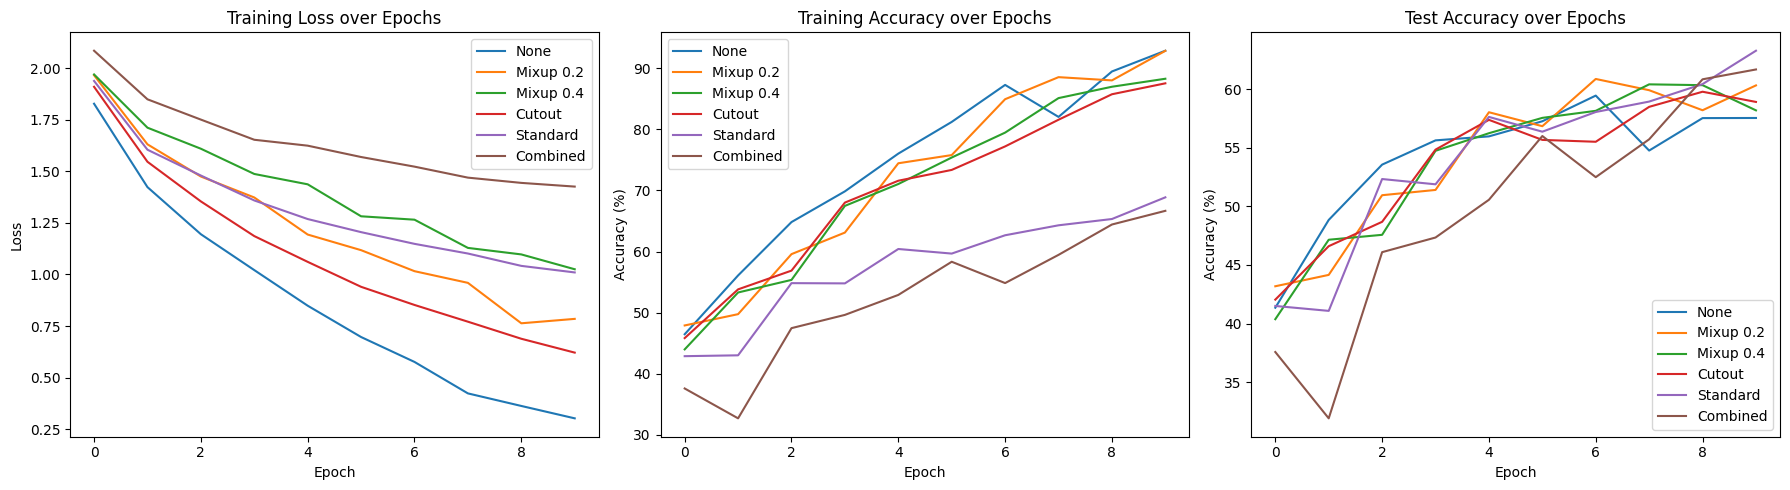

Final Test Accuracy for None: 57.54%
Final Test Accuracy for Mixup 0.2: 60.32%
Final Test Accuracy for Mixup 0.4: 58.19%
Final Test Accuracy for Cutout: 58.91%
Final Test Accuracy for Standard: 63.28%
Final Test Accuracy for Combined: 61.68%


In [14]:
def plot_results(histories, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, hist in enumerate(histories):
        axes[0].plot(hist['train_loss'], label=titles[i])
    axes[0].set_title('Training Loss over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    for i, hist in enumerate(histories):
        axes[1].plot(hist['train_acc'], label=titles[i])
    axes[1].set_title('Training Accuracy over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()

    for i, hist in enumerate(histories):
        axes[2].plot(hist['test_acc'], label=titles[i])
    axes[2].set_title('Test Accuracy over Epochs')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy (%)')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

histories = [
    history_no_aug,
    history_mixup_02,
    history_mixup_04,
    history_cutout,
    history_standard,
    history_combined
]
titles = [
    'None',
    'Mixup 0.2',
    'Mixup 0.4',
    'Cutout',
    'Standard',
    'Combined'
]

plot_results(histories, titles)
for title, hist in zip(titles, histories):
    print(f"Final Test Accuracy for {title}: {hist['test_acc'][-1]:.2f}%")
